# The Transportation Problem

**Objectives**
- Get familiar with transportation problem input.
- Use sensitivity analysis to explore how solutions change under different conditions.

**Key Ideas**
- Supply point and supply constraints
- Demand point and demand constraints
- Balanced transportation problem
- Bipartite graph
- Integrality property
- Sensitivity analysis

**Reading Assignment**
- Read the first part of Handout 7 on the transportation problem (first 4 pages)

**Brief description:** In this lab, we will consider several examples of problems that can be modeled as a transportation problem. We will also learn how Python and OR-Tools can help us represent and solve mathematical programming problems.

In [1]:
# imports
import pandas as pd
import numpy as np
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR

## Part 1: The Clicker Problem
*Adapted from Winston, page 390* 

Each fall, Cornell engineering faculty present to incoming freshmen about 
the various majors within the College of Engineering. 

Professor Quack (not from the ORIE department) decides to conduct information 
sessions on four consecutive days. The expected attendance for each day is as follows:

|day |attendees|
|----|---------|
| 1  |    15   |
| 2  |    12   |
| 3  |    18   |
| 4  |     6   |

P.Q., as her students call her, really loves iClickers for taking attendance and making people 
pay attention. Thankfully, she doesn't require attendees to bring their own; instead, she loans out 
iClickers from her private stash at each session, and has students return them at the end 
so she can use them in the future. (Of course, all Cornell students are perfect angels and return the clickers.)

After each session, any used iClicker must be reset by one of the following methods:
* Option 1: P.Q. "knows a guy" who resets iClickers in a day for \$10 apiece.
* Option 2: P.Q. can enlist ECE students to reset iClickers for \$6 per clicker. This takes two days.

As a last resort, P.Q. can just buy brand-new iClickers from the Cornell Store immediately for \$20 each.

It's the night before Day 1, and P.Q. can't find her secret stash! She asks us ENGRI 1101 students 
to come up with a plan for meeting the demand for clickers that minimizes her expenses.

Let's see how we can model this (very strange) situation as a balanced transportation problem!

**Q1:** First, think about the demand points. "Where" are clickers being demanded? What is the demand at each of these points? (Hint: there are four)

**A:** <font color='blue'> There are four demand points: one for each of the next four days. From the table, we see that these days have demand 15, 12, 18, and 6 clickers, respectively.</font>

**Q2:** Now think about the supply points. Clearly, one supply point is the Cornell Store. What are all the supply points? (Hint: what are all the ways we can supply clickers for the start of day 2? Day 3? Day 4?) What is the supply at each of these points?

**A:** <font color='blue'>Taking the hint, we might think about how we can supply clickers for day 2. One option is to buy them from the Cornell Store. However, we could also just reuse the clickers from day 1, if we reset them using Option 1! So another supply point might be the end of day 1. Now, for day 3, we can buy new clickers, or we can do Option 1 and reset clickers from Day 2, or we can do Option 2 and reset clickers from Day 1! So another supply point is the end of day 2. Following this reasoning for day 4, we see that the end of day 3 is also a supply point. 
    
Now we have our four supply points (the Cornell Store, and the ends of days 1, 2, and 3). What are their supplies? Well, the Cornell Store essentially has infinite supply. At the end of day 1, we have the clickers used for day 1, so the supply at this supply point is 15. Likewise, the "end of day 2" point has supply 12, and the "end of day 3" point has supply 18.</font>  

**Q3:** What is the per-unit shipping cost between each supply point and each demand point?

**A:** <font color='blue'> We obtain these vales from the text blob. The per-unit shipping cost between the Cornell Store supply node and every demand node is 20. The per-unit shipping cost between the supply node representing the end of day $i$ and the demand node representing day $i+1$ is 10, while the PUSC from this same supply node to the demand node for day $i+2$ is 6. </font>

**Q4:** Create a graphical representation of this input by combining your answers from Q1-Q3. Then, upload it as an image into the following (markdown) cell by entering the image name between the parentheses, if it is in the same folder as this lab. Make sure that your graph displays properly within the notebook before moving on!

**A:**
![q4-answer](your_image_here.ex)

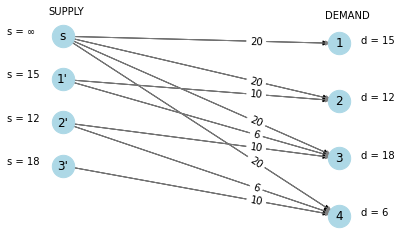

In [2]:
### BEGIN SOLUTION
'''
Run this cell for a NetworkX visualization of the solution graph for Q4. 

Note: in the student version, students will see two cells: a markdown cell, 
where they should upload their image, and an empty code cell (this cell) 
containing only the message "# don't use this cell".

If this cell doesn't work properly, the solution can be viewed by running
the following line in the MARKDOWN cell above, assuming notebook can
access the 'images-key' folder:

![q4-graph-key](images-key/q4_graph.png)
'''
from transportation import q4_graph
q4_graph()

# students will only see "# don't use this cell"
### END SOLUTION
# don't use this cell

We came up with the following formulation for the clicker problem, where the demand points are the four days $(1, 2, 3, 4)$ and the supply points are the Cornell Store ($s$) and the ends of the first three days $(1’, 2’, 3’)$. The supplies/demands and costs are summarized in the table below. Did you get a similar formulation?

|            | 1  | 2  | 3  | 4  | supply   |
|------------|----|----|----|----|----------|
| $s$        | 20 | 20 | 20 | 20 | $\infty$ |
| $1'$       | -  | 10 | 6  | -  | 15       |
| $2'$       | -  | -  | 10 | 6  | 12       |
| $3'$       | -  | -  | -  | 10 | 18       |
| **demand** | 15 | 12 | 18 | 6  |          |

**Q5:** Since we don't usually deal with infinity&mdash;although the Cornell Store probably does have an infinite supply of iClickers&mdash;can you posit a large enough value for the supply at $s$ that will allow us to always meet demand? (Hint: what if we need to buy new clickers every day?)

**A:** <font color='blue'> If we buy new clickers every day, then we'll need $15+12+18+6 = 51$ clickers from the store.</font>

**Q6:** As it stands, is our formulation balanced? If not, how could you convert it into a balanced transportation problem?

**A:** <font color='blue'> This formulation is not balanced because the total supply is $51 + 15 + 12 + 18 = 96$ while the total demand is only $15 + 12 + 18 + 6 = 51$. We can add a dummy demand node to make the formulation balanced. </font>

**Q7:** How might we interpret a dummy demand point in terms of clickers? (What clickers end up here, and what happens to them?)

**A:** <font color='red'>Wording on this question might be confusing</font>

<font color='blue'>Clickers that come to the dummy demand node are neither reset nor used; they're just stored away. We assume it costs nothing to store the clickers.</font>

**Q8:** Fill out the missing values (XXX) in the table below. (We substituted the dashes from above with a big enough number like 1000.)

|         | 1    | 2    | 3    | 4    | dummy | supplies |
|---------|------|------|------|------|-------|----------|
| $s$     | 20   | 20   | 20   | 20   | XXX   | 51       |
| 1'      | 1000 | 10   | 6    | 1000 | XXX   | 15       |
| 2'      | 1000 | 1000 | 10   | 6    | XXX   | 12       |
| 3'      | 1000 | 1000 | 1000 | 10   | XXX   | 18       |
| demands | 15   | 12   | 18   | 6    | XXX   |          |

<font color='blue'>

|         | 1    | 2    | 3    | 4    | dummy | supplies |
|---------|------|------|------|------|-------|----------|
| $s$     | 20   | 20   | 20   | 20   | 0     | 51       |
| 1'      | 1000 | 10   | 6    | 1000 | 0     | 15       |
| 2'      | 1000 | 1000 | 10   | 6    | 0     | 12       |
| 3'      | 1000 | 1000 | 1000 | 10   | 0     | 18       |
| demands | 15   | 12   | 18   | 6    | 45    |          |
    
</font>

## Part 2: Solving Using a Computer

The next cell contains our model. In later labs, you will practice writing your own models, but for now, read through the code and run it.

In [3]:
def transportation(data, integer=False):
    """A model for solving the transportation problem.
    
    Args:
        data (pd.DataFrame): Dataframe with demand, supplies, and cost matrix.
    """
    ORIG = list(data.index)[:-1]                                # origins
    DEST = list(data.columns)[:-1]                              # destinations
    supply = data['supply'][:-1].to_dict()                      # supply
    demand = data.transpose()['demand'][:-1].to_dict()          # demand
    cost = data.iloc[:-1,:-1].transpose().to_dict()
    cost = {(i,j) : cost[i][j] for i in cost for j in cost[i]}  # cost
    ARCS = list(cost)                                           # arcs
    
    # define model
    m = OR.Solver('transportation', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # decision variables
    x = {}  # units to be shipped on each edge
    for i,j in ARCS:
        if integer:
            x[i,j] = m.IntVar(0, m.infinity(), ('(%s, %s)' % (i,j))) 
        else:
            x[i,j] = m.NumVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
        
    # objective function
    m.Minimize(sum(cost[i,j]*x[i,j] for i,j in ARCS))
        
    # subject to: all supply delivered at each origin node
    for i in ORIG:
        m.Add(sum(x[i,j] for j in DEST) == supply[i])
        
    # subject to: demand met at each demand node
    for j in DEST:
        m.Add(sum(x[i,j] for i in ORIG) == demand[j])
    
    return m, x

In [4]:
def solve(m):
    m.Solve()
    print('Solution:')
    print('Objective value =', m.Objective().Value())
    for var in m.variables():
        print(var.name(), ':',  var.solution_value())

In [5]:
steel_data = pd.read_csv('data/transportation_steel.csv', index_col=0)
display(steel_data)

,FRA,DET,LAN,WIN,STL,FRE,LAF,supply
GARY,39,14,11,14,16,82,8,1400
CLEV,27,9,12,9,26,95,17,2600
PITT,24,14,17,13,28,99,20,2900
demand,900,1200,600,400,1700,1100,1000,6900


Here is an example set of data you can solve using this model. The `supply` column gives the tons of steel produced by three different steel mills. The `demand` row gives the tons of steel requested by each car manufacturer. The remaining portion of the dataframe gives the shipping cost per ton from each steel mill to each car manufacturer.

Run the next cell to solve this transportation problem!

In [6]:
m, x = transportation(steel_data) # create transportation model using given input
solve(m) # solve the model

Solution:
Objective value = 196200.0
(GARY, FRA) : 0.0
(GARY, DET) : 0.0
(GARY, LAN) : 0.0
(GARY, WIN) : 0.0
(GARY, STL) : 300.0
(GARY, FRE) : 1100.0
(GARY, LAF) : 0.0
(CLEV, FRA) : 0.0
(CLEV, DET) : 1200.0
(CLEV, LAN) : 600.0
(CLEV, WIN) : 400.0
(CLEV, STL) : 0.0
(CLEV, FRE) : 0.0
(CLEV, LAF) : 400.0
(PITT, FRA) : 900.0
(PITT, DET) : 0.0
(PITT, LAN) : 0.0
(PITT, WIN) : 0.0
(PITT, STL) : 1400.0
(PITT, FRE) : 0.0
(PITT, LAF) : 600.0


Now, let's use this model to solve the clicker problem! (Hint: the dummy node is labeled `d`)

In [7]:
clicker_data = pd.read_csv('data/transportation_caterer.csv', index_col=0)
display(clicker_data)

,1,2,3,4,d,supply
s,20,20,20,20,0,51
1',1000,10,6,1000,0,15
2',1000,1000,10,6,0,12
3',1000,1000,1000,10,0,18
demand,15,12,18,6,45,96


**Q9:** Does the table above match what you found in **Q8?** What did you get wrong?

**A:** <font color='blue'> Answers may vary. </font>

Run the cell below to create the transportation model and solve it.

Solution:
Objective value = 666.0
(s, 1) : 15.0
(s, 2) : 3.0
(s, 3) : 0.0
(s, 4) : 0.0
(s, d) : 33.0
(1', 1) : 0.0
(1', 2) : 9.0
(1', 3) : 6.0
(1', 4) : 0.0
(1', d) : 0.0
(2', 1) : 0.0
(2', 2) : 0.0
(2', 3) : 12.0
(2', 4) : 0.0
(2', d) : 0.0
(3', 1) : 0.0
(3', 2) : 0.0
(3', 3) : 0.0
(3', 4) : 6.0
(3', d) : 12.0


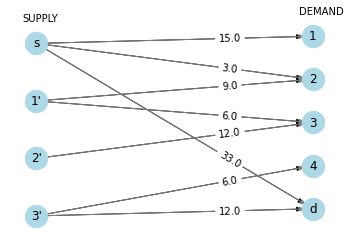

In [8]:
m, x = transportation(clicker_data)
solve(m)
from transportation import visualize_clicker_sol
visualize_clicker_sol(m)

**Q10:** Interpret the solution in words. How should P.Q. get clickers for each day?

**A:** <font color='blue'> The first day, she just has to buy all her clickers (15). She should then get 9 reset using Option 1 and 6 reset using Option 2. The 9 in addition to 3 new clickers satisfy the demand for the second day. After this, all 12 are reset using Option 1. These, along with 6 from the end of day 1, satisfy the demand for the third day. Lastly, 6 clickers are reset using Option 1 to be ready for the final day.</font>

**Q11:** How much cheaper is this plan than just buying new clickers every day?

**A:** <font color='blue'>Buying new clickers every day would cost P.Q. $(\$20)(15+12+18+6) = \$1020$, whereas this plan only costs $\$666$. So this plan reduces P.Q.'s expenses by $\$354$ (about 35%)!</font>

## Part 3: Exploring the Optimal Solution

We will start by solving a new problem. The Olive Oyl Oil Company imports crude oil from three different sources and refines it at five different refineries. Sources 1, 2, 3 can ship 20, 50, 20 barrels of crude oil each week, respectively. Refineries 1-5 need 10, 24, 6, 20, 30 barrels of crude oil each week, respectively. The table below contains the unit shipping costs from the sources to the refineries. The entry in the $i$th row and $j$th column gives the cost to ship from source $i$ to refinery $j$.

|    |    |    |    |    |
|----|----|----|----|----|
| 30 | 30 | 10 | 27 | 15 |
| 15 | 15 | 8  | 13 | 5  |
| 25 | 21 | 5  | 15 | 21 |

In [9]:
oil_data = pd.read_csv('data/transportation_oil.csv', index_col=0)
display(oil_data)

,R1,R2,R3,R4,R5,supply
S1,30,30,10,27,15,20
S2,15,15,8,13,5,50
S3,25,21,5,15,21,20
demand,10,24,6,20,30,90


In [10]:
m, x = transportation(oil_data)
solve(m)

Solution:
Objective value = 1160.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 6.0
(S1, R4) : 0.0
(S1, R5) : 14.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 16.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.0
(S3, R5) : 0.0


Now, consider the values $u(1) = 25$, $u(2) = 15$, $u(3) = 17$, $v(1) = 0$, $v(2) = 0$, $v(3) = -15$, $v(4) = -2$, and $v(5) = -10$.  

**Q12:** Write down the modified cost matrix, where as shown in class, we subtract $u(i)$ from every  entries in row $i$, and similarly we subtract $v(j)$ from each entry of column $j$. Argue as to why the solution computed above is indeed optimal for the original input.

**A:**

|    |    |    |    |    |
|----|----|----|----|----|
|    |    |    |    |    |
|    |    |    |    |    |
|    |    |    |    |    |

<font color='blue'> 
    
|    |    |    |    |    |
|----|----|----|----|----|
| 5  | 5  | 0  | 4  | 0  |
| 0  | 0  | 8  | 0  | 0  |
| 8  | 4  | 3  | 0  | 14 |

In the solution above, all non-zero $x_{ij}$ have modified cost equal to zero. Hence, the solution must be optimal. </font>

Now suppose that we anticipate the per-barrel shipping cost from source 1 to refinery 1 (currently 30) to go down. Observe that in the current optimal solution, we do not ship anything from source 1 to refinery 1. One interesting question we might ask is, "By how much can $c(1,1)$ decrease before we consider shipping some positive amount of barrels along that path?"

**Q13:** Try the following values for $c(1,1)$: 28, 26, 25, 24. Record the optimal solutions in the table. Also include the value $\overline{c}(1,1)$ from the matrix of modified costs (recall $\overline{c}(1,1) = c(1,1) - u(1) - v(1)$). What conclusions can you draw from this?

In [11]:
# change the value of c(1,1) here
oil_data.loc['S1','R1'] = 30

# re-solve
m, x = transportation(oil_data)
solve(m)

Solution:
Objective value = 1160.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 6.0
(S1, R4) : 0.0
(S1, R5) : 14.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 16.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.0
(S3, R5) : 0.0


**A:** 

|                     | 28          | 26          | 25         | 24 |
|---------------------|-------------|-------------|------------|----|
|                     | x(1,3) = XXX  | XXX | XXX | x(1,1) = XXX |   
|                     | x(1,5) = XXX |             |            | x(1,3) = XXX  |
|                     | x(2,1) = XXX |             |            | x(1,5) = XXX   |
|                     | x(2,2) = XXX |             |            | x(2,2) = XXX   |
|                     | x(2,5) = XXX |             |            | x(2,5) = XXX   |
|                     | x(3,4) = XXX |             |            | x(3,4) = XXX   |
| $\overline{c}$(1,1) |  XXX          |  XXX          |    XXX    | XXX |

<font color='blue'>

|                     | 28          | 26          | 25         | 24 |
|---------------------|-------------|-------------|------------|----|
|                     | x(1,3) = 6  | same as 28  | same as 28 | x(1,1) = 10 |   
|                     | x(1,5) = 14 |             |            | x(1,3) = 6  |
|                     | x(2,1) = 10 |             |            | x(1,5) = 4   |
|                     | x(2,2) = 24 |             |            | x(2,2) = 24   |
|                     | x(2,5) = 16 |             |            | x(2,5) = 26   |
|                     | x(3,4) = 20 |             |            | x(3,4) = 20   |
| $\overline{c}$(1,1) |  3          |  1          |      0     | -1 |

Once the modified cost becomes negative, the edge will enter the solution. (It could enter when the modified cost is zero, though.)</font>

Now consider the original model with $c(1,1) = 30$. Make sure to run the cell below to reset the value.

In [12]:
oil_data.loc['S1','R1'] = 30

**Q14:** Is it possible to use the modified cost matrix from above to answer the same kind of question for changes in any single $c(i,j)$ parameter? Using your observations, try to figure out by how much the value of $c(2,3)$ needs to be reduced for us to consider shipping from source 2 to refinery 3. 

**A:** <font color='blue'> From the modified cost matrix, we see that the value of $c(2,3)$ needs to be decreased by at least 8 for the edge to enter the solution.</font>

In [13]:
# run this cell to check your answer (optional)
oil_data.loc['S2','R3'] = 8 - 0 # replace 0 with your answer
m, x = transportation(oil_data)
solve(m)

Solution:
Objective value = 1160.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 6.0
(S1, R4) : 0.0
(S1, R5) : 14.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.0
(S2, R5) : 16.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.0
(S3, R4) : 20.0
(S3, R5) : 0.0


Let's return to the original model and data. 

The Olive Oyl Oil Company imports its oil from the two dominant oil suppliers in the region: Sinbad's Slightly Crude Oil, which controls sources 1 and 3, and its archrival Popeye's Pretty Crude Oil, which controls source 2.

The OOOC enters into a trade agreement with Sinbad's that imposes the following restriction: the amount of crude oil shipped from Popeye's source (source 2) to refinery 5 cannot exceed the amount that Sinbad's sources (sources 1 and 3) combined ship to refinery 5 by more than 1 barrel. 

In the cell below, we add this constraint to the model before solving. Run it to see what happens!

In [14]:
# reset cost matrix if necessary 
oil_data.loc['S1','R1'] = 30
oil_data.loc['S2','R3'] = 8

# solve model with added constraint
m, x = transportation(oil_data)
m.Add(x['S2','R5'] <= x['S1','R5'] + x['S3','R5'] + 1)
solve(m)

Solution:
Objective value = 1161.5
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 5.5
(S1, R4) : 0.0
(S1, R5) : 14.5
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 0.5
(S2, R5) : 15.5
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 0.5
(S3, R4) : 19.5
(S3, R5) : 0.0


**Q15:** How does the objective value of this solution compare to that of previous solutions? After adding the trade agreement constraint, what property no longer holds?

**A:** <font color='blue'> The objective value is higher (worse) than previous solutions, and the integrality property no longer holds.</font>

Since the shipping is done in barrels, we'd like the optimal solution to have only integer flow values. To enforce this, we'll set the model parameter `integer` to `True`. Again, we include our new trade agreement constraint before solving.

In [15]:
m, x = transportation(oil_data, integer=True)
m.Add(x['S2','R5'] <= x['S1','R5'] + x['S3','R5'] + 1)
solve(m)

Solution:
Objective value = 1163.0
(S1, R1) : 0.0
(S1, R2) : 0.0
(S1, R3) : 5.0
(S1, R4) : 0.0
(S1, R5) : 15.0
(S2, R1) : 10.0
(S2, R2) : 24.0
(S2, R3) : 0.0
(S2, R4) : 1.0
(S2, R5) : 15.0
(S3, R1) : 0.0
(S3, R2) : 0.0
(S3, R3) : 1.0
(S3, R4) : 19.0
(S3, R5) : 0.0


**Q16:** Note that the optimal objective value here (1163.0) is higher than it was before we added the integrality constraint (1161.5). Explain why this value can never be lower than 1161.5, the optimal value before we added the constraint that the number of barrels shipped along each path must be integer.

**A:** <font color='blue'> By constraining our decision variables to be integer, we decrease the feasible region of our problem. Doing so tightens the number of feasible solutions, so our optimal solution here will never be better/lower in cost (i.e., it will always be equal or worse/higher in cost) than the original problem's optimal solution.</font>